# Task 1: Comparison of optimization methods for classification on Image dataset

Model: MLFFNN with 2 hidden layers and tanh activation function
- Loss function: Cross-entropy
- Mode of learning: Pattern mode
- Stopping criterion: Change in average error below a threshold
- Weight update rules: 
    1. Delta rule,
    2. Generalized delta rule,
    3. AdaGrad,
    4. RMSProp,
    5. AdaM
- Use the same value of learning rate parameter
- Use the same initial random values of weights
- For each rule of weight update, report should include the following: 
    1. Plot of average error on training data vs Epoch, 
    2. Confusion matrices for training data and test data
- Compare number of epochs taken for convergence for different update rules.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [21]:
# Data Preparation
feature_names = ["feature_" + str(i+1) for i in range(36)]

train_data = pd.read_csv("task 1/train_data.csv", names = feature_names)
train_labels = pd.read_csv("task 1/train_label.csv", names = ["label"])
print(f"The shape of the train_data is {train_data.shape} and there are {len(train_labels.label.unique())} labels in train data")
print(f"The shape of the train_labels is {train_labels.shape}")
print()

val_data = pd.read_csv("task 1/val_data.csv", names = feature_names)
val_labels = pd.read_csv("task 1/val_label.csv", names = ["label"])
print(f"The shape of the train_data is {val_data.shape} and there are {len(val_labels.label.unique())} labels in validation data")
print()

test_data = pd.read_csv("task 1/val_data.csv", names = feature_names)
test_labels = pd.read_csv("task 1/val_label.csv", names = ["label"])
print(f"The shape of the train_data is {test_data.shape} and there are {len(test_labels.label.unique())} labels in validation data")

The shape of the train_data is (2000, 36) and there are 5 labels in train data
The shape of the train_labels is (2000, 1)

The shape of the train_data is (500, 36) and there are 5 labels in validation data

The shape of the train_data is (500, 36) and there are 5 labels in validation data


In [22]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() # instantiate the nn.Module
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Input layer --> First Hidden layer --> Second Hidden Layer --> Output
        self.itoh = nn.Linear(input_size, hidden_size)
        self.htoh = nn.Linear(hidden_size, hidden_size)
        self.htoo = nn.Linear(hidden_size, output_size)
        
        # Since we have more than two labels to predict
        self.logSoftmax = nn.LogSoftmax()
    
    def forward(self, x):
        x = F.tanh(self.itoh(x))
        x = F.tanh(self.htoh(x))
        x = self.logSoftmax(self.htoo(x))
        
        return x

In [23]:
# We want out data to be in tensor data type
X_train = torch.FloatTensor(train_data.values)
Y_train = torch.LongTensor(train_labels.values)
X_val = torch.FloatTensor(val_data.values)
Y_val = torch.LongTensor(val_labels.values)
X_test = torch.FloatTensor(test_data.values)
Y_test = torch.LongTensor(test_labels.values)

In [45]:
# Set Seed
torch.manual_seed(0)

# Create a model using the class
input_size = len(train_data.columns)
hidden_size = input_size // 2
output_size = len(train_labels.label.unique())
lr = 0.01

# Define Optimizers
optimizers = {
    "Delta": None,
    "AdaDelta": None,
    "AdaGrad": None,
    "RMSProp": None,
    "AdaM": None
}

# Define stopping criterion parameters
patience = 10  # Number of epochs to wait for improvement
threshold = 1e-5  # Minimum change in loss to continue
convergence_epochs = {}
Test_accuracy = {}

for name in optimizers.keys():
    model = Model(input_size, hidden_size, output_size)
    
    if name == "Delta":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif name == "AdaDelta": 
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    elif name == "AdaGrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    elif name == "RMSProp": 
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif name == "AdaM":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Set Loss Criteria
    lossCriteria = nn.CrossEntropyLoss()

    # Training Loop
    Epochs = 100

    Train_loss = []
    Validation_loss = []

    # Initialize variables for stopping criteria
    best_val_loss = float("inf")
    no_improve_epochs = 0  # Counter for non-improvement epochs

    for e in range(1, Epochs+1):

        model.train()

        Y_pred = model.forward(X_train)
        # The crossentropy loss expects the train labels to be of dimension 1 only so we need to squeeze it.
        loss = lossCriteria(Y_pred, Y_train.squeeze(dim=1))
        Train_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation check
        model.eval()
        with torch.no_grad():
            Y_val_pred = model.forward(X_val)
            val_loss = lossCriteria(Y_val_pred, Y_val.squeeze(dim=1))
            Validation_loss.append(val_loss.item())

        # Print losses every 50 epochs
        if e % 50 == 0:
            print(f"[{name}] Epoch {e}: Training Loss = {loss.item():.4f}, Validation Loss = {val_loss.item():.4f}")

        # Check stopping criterion
        if val_loss.item() < best_val_loss - threshold:
            best_val_loss = val_loss.item()
            no_improve_epochs = 0  # Reset counter if there's an improvement
        else:
            no_improve_epochs += 1  # Increment counter if no significant improvement

        if no_improve_epochs >= patience:
            convergence_epochs[name] = e
            print(f"[{name}] Early stopping at epoch {e}: No improvement in validation loss for {patience} epochs.")
            break
    
    model.eval()
    with torch.no_grad():
        Y_test_pred = model.forward(X_test).argmax(dim=1)
        accuracy = accuracy_score(Y_test_pred.numpy(), Y_test.squeeze(dim=1))
        Test_accuracy[name] = accuracy
    optimizers[name] = {"TrainingLoss": Train_loss, "Validationloss": Validation_loss}

/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Delta] Epoch 50: Training Loss = 1.6084, Validation Loss = 1.6077
[Delta] Epoch 100: Training Loss = 1.6072, Validation Loss = 1.6066


/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[AdaDelta] Epoch 50: Training Loss = 1.6238, Validation Loss = 1.6230
[AdaDelta] Epoch 100: Training Loss = 1.6221, Validation Loss = 1.6213


/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[AdaGrad] Epoch 50: Training Loss = 1.2971, Validation Loss = 1.2960
[AdaGrad] Epoch 100: Training Loss = 1.1831, Validation Loss = 1.1896


/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[RMSProp] Early stopping at epoch 48: No improvement in validation loss for 10 epochs.
[AdaM] Epoch 50: Training Loss = 1.0576, Validation Loss = 1.0766
[AdaM] Epoch 100: Training Loss = 0.9931, Validation Loss = 1.0358


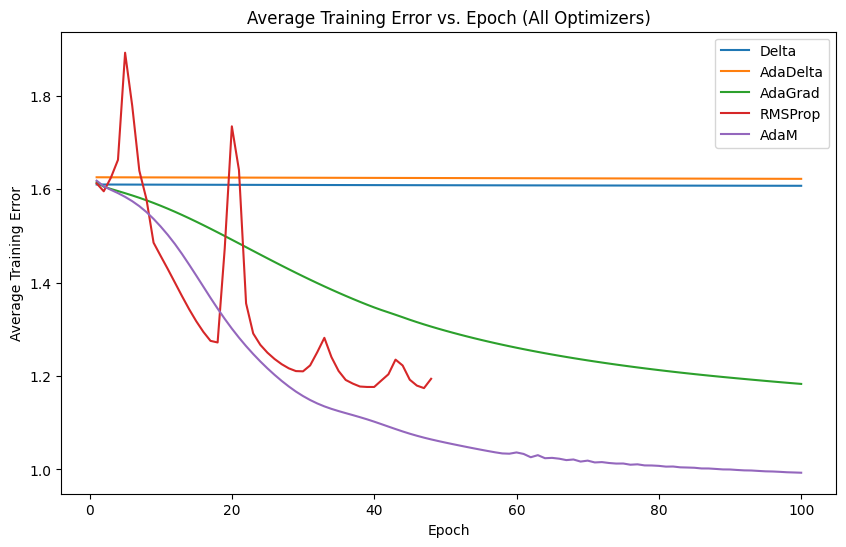

RMSProp converged in 48 epochs.
The test accuracy for Delta = 0.2.
The test accuracy for AdaDelta = 0.204.
The test accuracy for AdaGrad = 0.52.
The test accuracy for RMSProp = 0.466.
The test accuracy for AdaM = 0.592.


In [46]:
# (a) Combined Plot for All Optimizers
plt.figure(figsize=(10, 6))
for name, losses in optimizers.items():
    plt.plot(range(1, len(losses["TrainingLoss"]) + 1), losses["TrainingLoss"], label=name)
    # plt.plot(range(1, len(losses["Validationloss"]) + 1), losses["Validationloss"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Average Training Error")
plt.title("Average Training Error vs. Epoch (All Optimizers)")
plt.legend()
plt.show()

# Compare convergence epochs
for name, epoch in convergence_epochs.items():
    print(f"{name} converged in {epoch} epochs.")
    
# Compare accuracy
for name, accuracy in Test_accuracy.items():
    print(f"The test accuracy for {name} = {accuracy}.")